In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv("Clean_House_data.csv")
data.head()

,City,Price,Number_Beds,Number_Baths,Province,Population,Latitude,Longitude,Median_Family_Income,log_price
0,Toronto,779900.0,3,2,ON,5647656,43.7417,-79.3733,97000.0,5.892039
1,Toronto,799999.0,3,1,ON,5647656,43.7417,-79.3733,97000.0,5.903089
2,Toronto,799900.0,2,2,ON,5647656,43.7417,-79.3733,97000.0,5.903036
3,Toronto,1200000.0,4,2,ON,5647656,43.7417,-79.3733,97000.0,6.079181
4,Toronto,668800.0,1,1,ON,5647656,43.7417,-79.3733,97000.0,5.825296


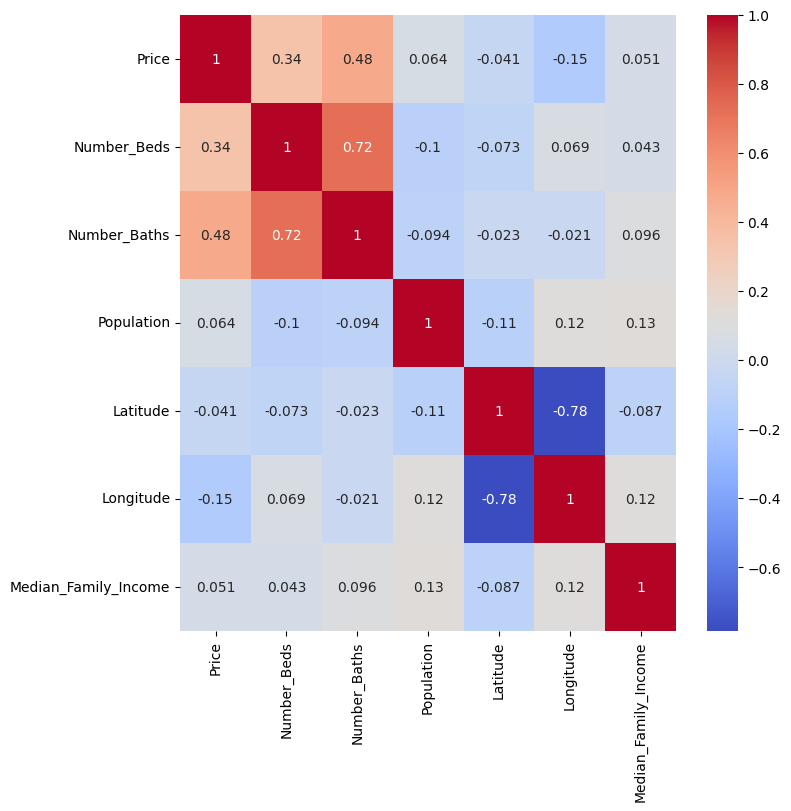

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
sns.heatmap(data[['Price', 'Number_Beds', 'Number_Baths','Population', 'Latitude', 'Longitude', 'Median_Family_Income']].corr(), cmap="coolwarm", annot=True)
plt.show()

### 🔍 Feature Correlation Analysis

Before building the prediction model, I analyzed the relationship between features using a correlation heatmap. This helps to identify which features are strongly related to the target variable (**Price**) and to each other.

From the heatmap above, we can observe:

- 🛁 **Number of Bathrooms** has the strongest positive correlation with **Price** (0.48).
- 🛏️ **Number of Beds** also shows a moderate positive correlation with **Price** (0.34).
- 🌍 **Longitude** has a negative correlation with **Price** (-0.15), which may reflect geographic differences in housing prices.
- 📍 **Latitude and Longitude** are highly negatively correlated with each other (-0.78), meaning we may only need one of them to represent location.
- 👫 **Population** and **Median Family Income** have weak correlations with **Price**, but might still be useful when combined with other features.

### ✅ Feature Selection Decisions

- Both **Number_Beds** and **Number_Baths** will be kept since they contribute to price prediction.
- Due to strong correlation, **only one of Latitude or Longitude** will be selected to avoid redundancy.
- Although **Province** and **City** are categorical, I decided not to include them directly. Instead, **Latitude and Longitude** will be used to represent location more precisely as numeric values.

### 🔁 Logarithmic Transformation

Since the distribution of **Price** is **right-skewed**, a **logarithmic transformation** will be applied to normalize the data.  
This helps improve model performance by reducing the impact of extreme values or outliers in price.

These preprocessing steps prepare the dataset for training an XGBoost regression model effectively.


In [4]:
ml_data = data.copy()
ml_data.drop(["City","Province"],axis = 1,inplace = True)
ml_data['log_price'] = np.log10(ml_data['Price'])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(ml_data.drop(["log_price","Price","Longitude","Median_Family_Income","Population",],axis = 1), (ml_data["log_price"]), test_size= 0.2, random_state= 21)

In [6]:
X_train.head()

,Number_Beds,Number_Baths,Latitude
10099,3,1,42.9836
2365,1,1,49.2500
30332,5,5,43.8667
25705,1,1,49.0250
17030,3,2,47.4817


In [7]:
def objective(params):
    xgb_model = XGBRegressor(**params)
    score = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2').mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the search space
max_depth_values = list(range(1, 10))
n_estimators_values = list(range(100, 1000,100))

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.4),
    'max_depth': hp.choice('max_depth', max_depth_values),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'n_estimators': hp.choice('n_estimators', n_estimators_values),

}

trials = Trials()
best = fmin(fn= objective, space= space, algo= tpe.suggest, max_evals= 25, trials= trials)
print("Best parameters found: ", best)

100%|██████████| 25/25 [01:17<00:00,  3.08s/trial, best loss: -0.6949073780243636]
Best parameters found:  {'colsample_bytree': np.float64(0.92763936070093), 'learning_rate': np.float64(0.1630062027463292), 'max_depth': np.int64(3), 'n_estimators': np.int64(3), 'subsample': np.float64(0.8143555273031143)}


In [8]:
def ml_model():
  model = XGBRegressor(learning_rate = best["learning_rate"], colsample_bytree = best["colsample_bytree"], max_depth = max_depth_values[best["max_depth"]],
                       subsample = best["subsample"], n_estimators = n_estimators_values[best["n_estimators"]])
  model.fit(X_train,y_train)
  return model

In [9]:
### Model Performance
print("MSE Test Error: "       , mean_squared_error(y_test,ml_model().predict(X_test)))
print("R Squared Test Error: " ,  r2_score(y_test,ml_model().predict(X_test)))
print("R Squared Train Error: ", r2_score(y_train,ml_model().predict(X_train)))

MSE Test Error:  0.028328556192171422
R Squared Test Error:  0.6944621748660467
R Squared Train Error:  0.7090337766365707


##Feature Importance:

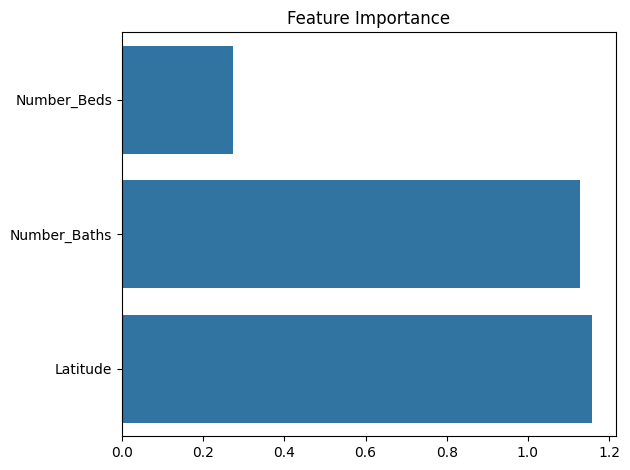

In [10]:
feature_importance = ml_model().get_booster().get_score(importance_type='gain')
sns.barplot(x=list(feature_importance.values()), y=list(feature_importance.keys()))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

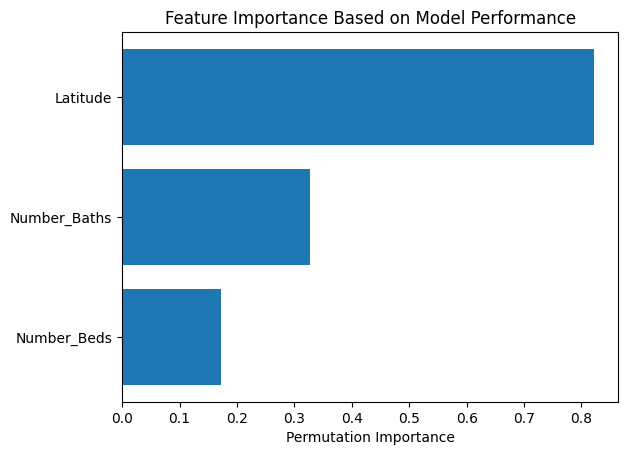

In [11]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(ml_model(), X_test, y_test, scoring="r2")
sorted_idx = np.argsort(perm_importance.importances_mean)
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance Based on Model Performance")
plt.show()

📊 Comparing Two Feature Importance Results
To better understand which features help the model the most, I looked at two ways of measuring feature importance:

Feature Importance from XGBoost – This shows how often each feature was used by the model to make decisions.

Permutation Importance – This shows how much the model’s performance drops when each feature is randomly shuffled.

🔹 Results:
In both plots, Latitude had the highest importance, meaning it played the biggest role in predicting house prices.

Number_Baths came second in both methods, showing that it also had a strong influence.

Number_Beds had the lowest importance in both plots, so it helped the model the least.

✅ Summary:
The results from both methods match closely, which is a good sign. The model relies mostly on Latitude and Number_Baths, while Number_Beds has a smaller effect. This helps confirm that the model is learning patterns based on meaningful features.

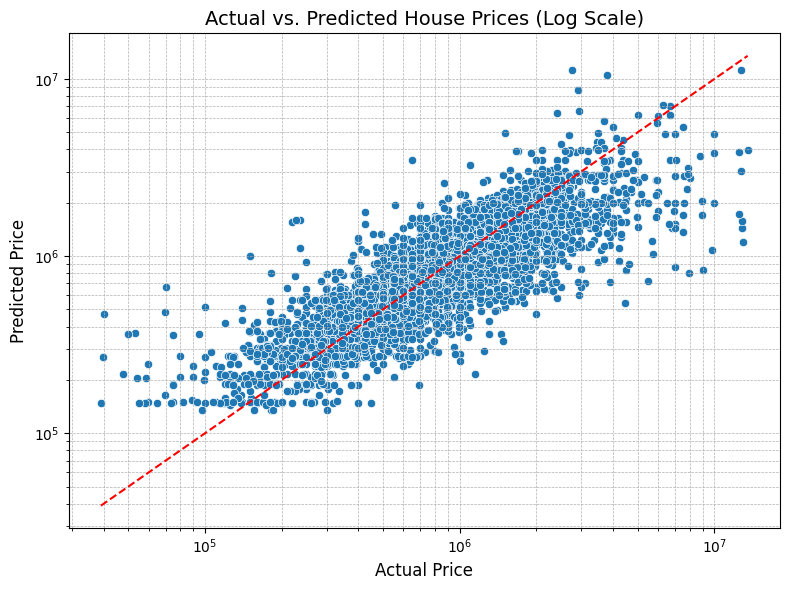

In [12]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
y_true = 10 ** y_test
y_pred = 10 ** ml_model().predict(X_test)
sns.scatterplot(x = 10** y_test, y = 10 ** ml_model().predict(X_test) , marker='o', linestyle='-', )
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfect Prediction')
plt.xlabel("Actual Price", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("Actual vs. Predicted House Prices (Log Scale)", fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

📊 Actual vs. Predicted Price (Log Scale)
This scatter plot shows how close the predicted house prices are to the actual prices.
Each point is one house, with:

X-axis: The actual price (in log scale)

Y-axis: The predicted price by the model (also in log scale)

We used a log scale because house prices vary a lot, and using the log helps spread out the points and makes patterns easier to see.

🔍 What the plot tells us:
Most points are close to the diagonal line, meaning the model predicted those prices fairly well.

A few dots are far from the line, which means the model had trouble with those houses — it either overestimated or underestimated their price.

The overall shape shows a clear trend, which means the model has learned the general pattern of how price changes with the features.

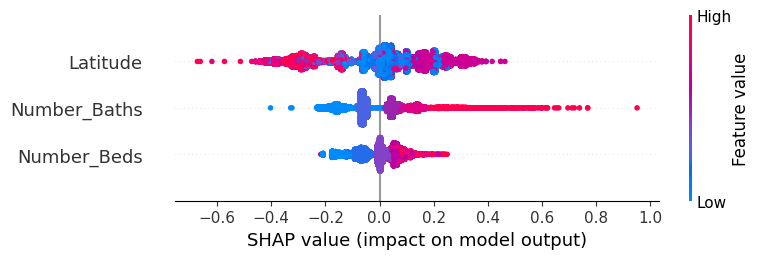

In [13]:
import shap

explainer = shap.TreeExplainer(ml_model())
shap_values = explainer.shap_values(X_train)
features = X_train.columns.tolist()
shap.summary_plot(shap_values, X_train, feature_names=features)

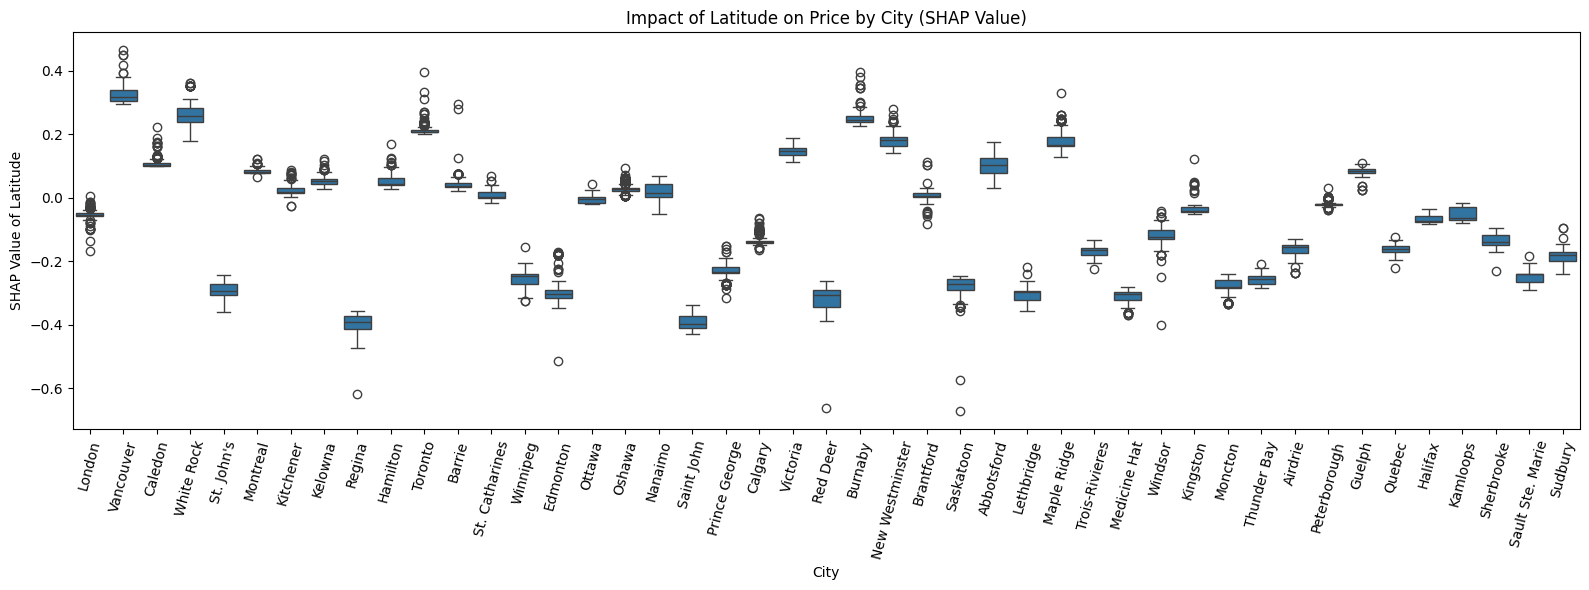

In [16]:
temp_df = X_train.copy()
temp_df['SHAP_Latitude'] = shap_values[:, X_train.columns.get_loc("Latitude")]
temp_df['City'] = data['City']

# Plot boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(x='City', y='SHAP_Latitude', data=temp_df)
plt.xticks(rotation=75)
plt.title("Impact of Latitude on Price by City (SHAP Value)")
plt.ylabel("SHAP Value of Latitude")
plt.show()

### 🤖 SHAP Summary Plot – Feature Impact on Price Prediction

The SHAP plot above shows how each feature affects the model’s prediction for house prices. Each dot is a single prediction (row of data), and:

- **Color** shows the feature value (blue = low, red = high).
- **Position on x-axis** shows whether the value increased (right) or decreased (left) the predicted price.

#### 🔹 Key Insights:

- **Latitude**: Has a strong impact. Lower latitudes (red dots on the right) increase the predicted price, which suggests that homes in southern cities (e.g., Toronto, Vancouver) tend to be more expensive.
  
- **Number_Baths**: Higher values (red) push predictions up. More bathrooms generally increase house price.
  
- **Number_Beds**: Also contributes positively, but not as strongly. Homes with more bedrooms slightly raise the predicted price.

This plot helps explain how the model makes decisions and which features matter most for individual predictions.


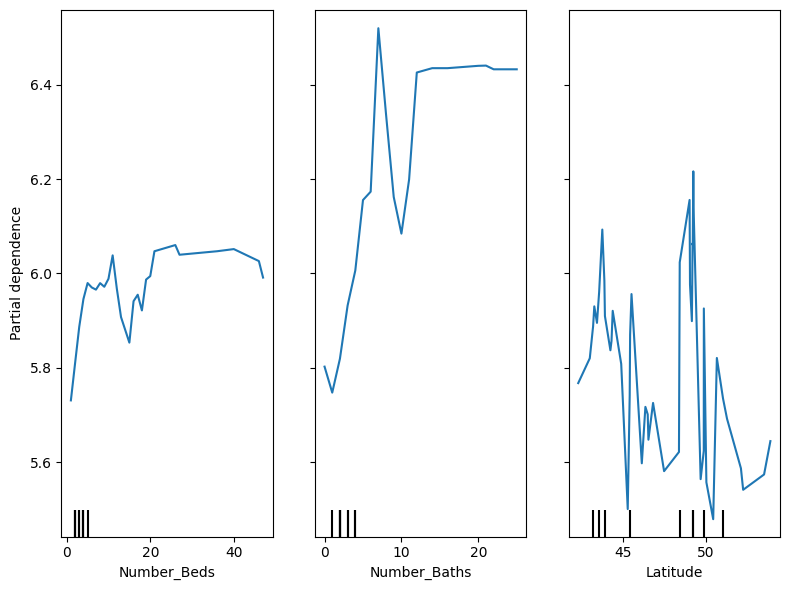

In [21]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

PartialDependenceDisplay.from_estimator(ml_model(), X_train, features = features)
plt.show()

##🔍 Partial Dependence Plots:
The charts above show how each feature (like number of beds, baths, and latitude) affects house prices, based on our model.

##🛏️ Number of Beds
When the number of bedrooms increases from 1 to around 5, the predicted house price also increases.

After 5 bedrooms, the line becomes flat — this means adding more bedrooms doesn’t change the price much.

##🛁 Number of Baths
More bathrooms generally lead to higher house prices.

The line goes up clearly, so bathrooms are an important factor in price.

##📍 Latitude
The line goes up and down a lot, showing that location (north vs. south) has different effects on house prices.

This means some areas (like southern cities) may raise prices more than others.

## 🏁 Final Summary

- The XGBoost model achieved an **R² score of 0.70** on both the **training** and **test** sets.  
  This means the model explains about **70% of the variation** in house prices based on the selected features.

- To improve performance, **hyperparameter tuning with cross-validation** was applied.  
  This helped find the best combination of model settings.

---

### ⚠️ Missing Information

Some important details were not available in the dataset, which could have improved the predictions:

- **Neighborhood-level data** within each city (some areas are more expensive)
- **House or land area**
- Other characteristics like **year built**, **number of floors**, or **house condition**

---

### ✅ Final Thoughts

Even with a limited set of features like:

- `Latitude`
- `Number_Beds`
- `Number_Baths`

The model still performed reasonably well and showed useful patterns in the housing data
